Integrantes:

David Bugoi

Fernando Javier Gómez Márquez

Daniel Hernández Martínez

### Carga de datos

Dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import os.path

In [79]:
RANDOM_STATE = 813

In [80]:
def genera_df(ficherocsv, nro_filas=None):
    try:
      from google.colab import drive
      drive.mount('/content/drive')
      df = pd.read_csv(os.path.join('drive/MyDrive/Colab Notebooks/',ficherocsv), nrows=nro_filas)
    except:   # si no es en google colab, se supone que estamos ejecutando el notebook en nuestro servidor local y que el fichero está en el mismo directorio
      df = pd.read_csv(ficherocsv, nrows=nro_filas)
    return df

In [81]:
fdatos = 'heart.csv'
df = genera_df(fdatos)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Preparar conjuntos de datos para entrenamiento, pruebas y validación

In [83]:
X = df.drop(['HeartDisease'], axis=1).values
Y = df['HeartDisease'].values

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state = RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state = RANDOM_STATE)

print(X_train.shape, X_test.shape, X_val.shape)

(743, 11) (92, 11) (83, 11)


Preparar y aplicar OneHotEncoder

In [85]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)
X_val_enc = enc.transform(X_val)

Identificar función de coste de acuerdo a la versión de sklearn

In [86]:
import sklearn
if (sklearn.__version__ < "1.1.0"):
  funcion_coste = 'log'
else:
  funcion_coste = 'log_loss'
funcion_coste

'log_loss'

**Entrenamiento con diferentes parámetros**

In [87]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

Parámetros y valores a comprobar con el modelo de regresión logística

|Param|Values|
|--|--|
|penalty | None , L1|
|max_iter | 10 , 100 |
|learning_rate | constant , optimal |
|alpha (learning_rate=optimal) | 0.00001 ,	0.0001 ,	0.001 ,	0.01 ,	0.1 ,	1	, 10 |
|eta0 (learning_rate=constant) | 0.001 ,	0.01	, 0.1	, 1	, 10 |





In [88]:
penalties = [None,'l1']
iterations = [10,100]
learning_rates = ['constant','optimal']
alphas = [0.00001 ,	0.0001 ,	0.001 ,	0.01 ,	0.1 ,	1	, 10]
etas = [0.001 ,	0.01	, 0.1	, 1	, 10]

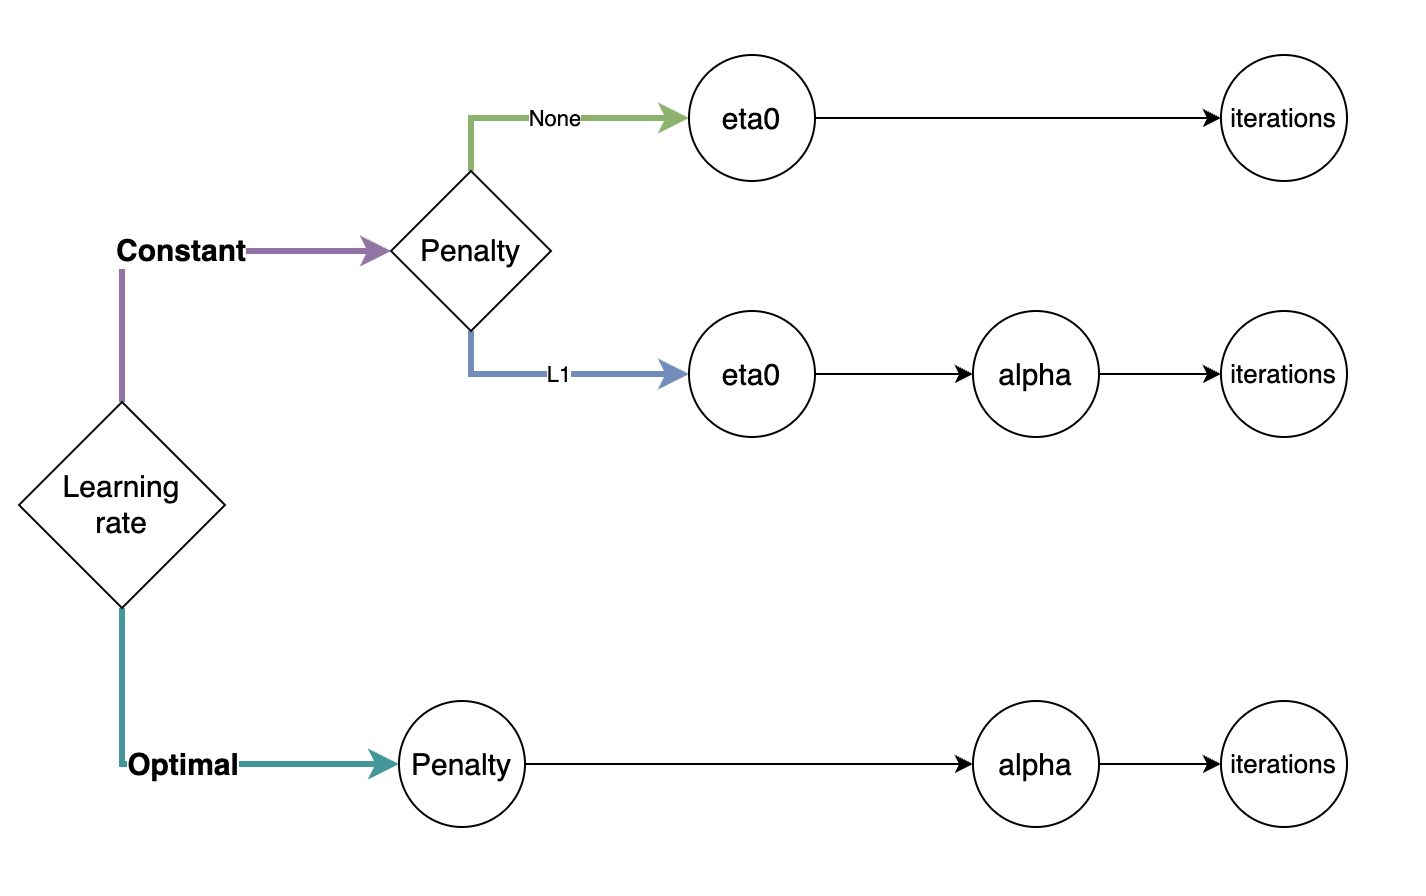

In [89]:
import warnings
warnings.filterwarnings('ignore')

## Train Model
def logTrain(args): # penalty, max_iter, learning_rate, alpha, eta0
  log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, **args)
  log_classifier.fit(X_train_enc.toarray(), Y_train)
  # Generate prediction
  prediction = log_classifier.predict(X_test_enc)
  # Calculate accuracy
  accuracy = accuracy_score(Y_test,prediction)
  return accuracy

# Table structure
# learning_rate penalty eta alpha max_iterations accuracy 
results = []

for learning_rate in learning_rates:
  for penalty in penalties:
    if learning_rate == 'optimal': # Skip eta0
      for alpha in alphas:
        for iteration in iterations:
          print('=> learning_rate [{rate}] Penalty [{penalty}] eta0 [XX] alpha [{alpha}]  max_iterations [{iteration}]'.format(rate=learning_rate, penalty=penalty, alpha=alpha, iteration=iteration),end='')

          accuracy = logTrain({'learning_rate':learning_rate, 'penalty':penalty, 'max_iter':iteration, 'alpha':alpha })
          
          results.append([learning_rate, penalty, 'XX', alpha, iteration, accuracy])
          print('    ==> Accuracy: {acc} '.format(acc=accuracy))
           
    else:
      if penalty is None:
        for eta in etas:
          for iteration in iterations:
            print('=> learning_rate [{rate}] Penalty [{penalty}] eta0 [{eta}] alpha [XX]  max_iterations [{iteration}]'.format(rate=learning_rate, penalty=penalty, eta=eta, iteration=iteration),end='')

            accuracy = logTrain({'learning_rate':learning_rate, 'penalty':penalty, 'max_iter':iteration, 'eta0':eta })

            results.append([learning_rate, penalty, eta, 'XX', iteration, accuracy])
            print('    ==> Accuracy: {acc} '.format(acc=accuracy))
            
      else:
        for eta in etas:
          for alpha in alphas:
            for iteration in iterations:
              print('=> learning_rate [{rate}] Penalty [{penalty}] eta0 [{eta}] alpha [{alpha}]  max_iterations [{iteration}]'.format(rate=learning_rate, penalty=penalty, eta=eta, alpha=alpha, iteration=iteration),end='')

              accuracy = logTrain({'learning_rate':learning_rate, 'penalty':penalty, 'max_iter':iteration, 'eta0':eta, 'alpha':alpha })

              results.append([learning_rate, penalty, eta, alpha, iteration, accuracy])
              print('    ==> Accuracy: {acc} '.format(acc=accuracy))
              

print("Numero de entrenamientos: {total}".format(total=len(results)))


=> learning_rate [constant] Penalty [None] eta0 [0.001] alpha [XX]  max_iterations [10]    ==> Accuracy: 0.8478260869565217 
=> learning_rate [constant] Penalty [None] eta0 [0.001] alpha [XX]  max_iterations [100]    ==> Accuracy: 0.8478260869565217 
=> learning_rate [constant] Penalty [None] eta0 [0.01] alpha [XX]  max_iterations [10]    ==> Accuracy: 0.8478260869565217 
=> learning_rate [constant] Penalty [None] eta0 [0.01] alpha [XX]  max_iterations [100]    ==> Accuracy: 0.8152173913043478 
=> learning_rate [constant] Penalty [None] eta0 [0.1] alpha [XX]  max_iterations [10]    ==> Accuracy: 0.8260869565217391 
=> learning_rate [constant] Penalty [None] eta0 [0.1] alpha [XX]  max_iterations [100]    ==> Accuracy: 0.7934782608695652 
=> learning_rate [constant] Penalty [None] eta0 [1] alpha [XX]  max_iterations [10]    ==> Accuracy: 0.7608695652173914 
=> learning_rate [constant] Penalty [None] eta0 [1] alpha [XX]  max_iterations [100]    ==> Accuracy: 0.75 
=> learning_rate [consta

**Manejando los resultados de los modelos entrenados**

Establecer un umbral de precisión del 0,75

In [94]:
results_df = pd.DataFrame(results,columns=['learning rate','penalty','eta0','alpha','max iterations','accuracy'])
threshold = 0.75
results_top = results_df[results_df['accuracy'] > threshold].sort_values(by='accuracy',ascending=False)
results_top.head(10)

,learning rate,penalty,eta0,alpha,max iterations,accuracy
90,optimal,None,XX,1,10,0.880435
17,constant,l1,0.001,0.01,100,0.869565
28,constant,l1,0.01,0.001,10,0.858696
89,optimal,None,XX,0.1,100,0.858696
16,constant,l1,0.001,0.01,10,0.858696
91,optimal,None,XX,1,100,0.858696
14,constant,l1,0.001,0.001,10,0.858696
0,constant,None,0.001,XX,10,0.847826
42,constant,l1,0.1,0.001,10,0.847826
15,constant,l1,0.001,0.001,100,0.847826


In [95]:
learning_rate, penalty, eta, alpha, iteration, accuracy = results_top.iloc[0]

params = {'learning_rate':learning_rate, 'penalty':penalty, 'max_iter':iteration}

if eta is not 'XX':
  params['eta0']=eta

if alpha is not 'XX':
  params['alpha']=alpha

params

{'learning_rate': 'optimal', 'penalty': None, 'max_iter': 10, 'alpha': 1}

**ANÁLISIS CON EL MEJOR DE LOS CASOS**

{'learning_rate': 'optimal', 'penalty': None, 'max_iter': 10, 'alpha': 1}
Precisión (Acurracy) :  86.96%
Puntuación de validación cruzada(Cross Validation Score) con Train :  90.83%
Puntuación de validación cruzada(Cross Validation Score) con Val :  95.96%
Puntuación ROC_AUC :  86.93%


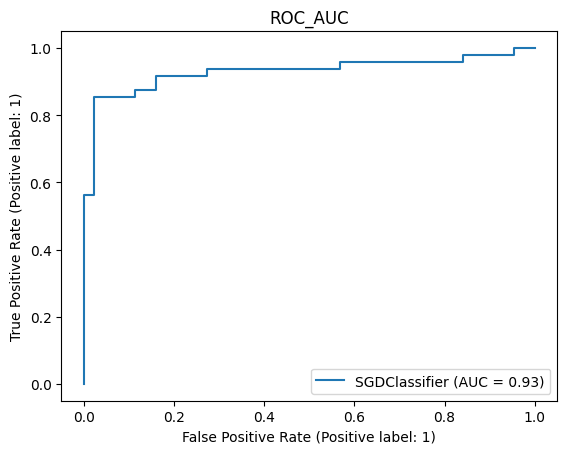

In [96]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import RocCurveDisplay

print(params)
log_classifier = SGDClassifier(loss=funcion_coste,  fit_intercept=True, **params)
log_classifier.fit(X_train_enc.toarray(), Y_train)
# Generate prediction
prediction = log_classifier.predict(X_test_enc)
# Calculate accuracy
accuracy = accuracy_score(Y_test,prediction)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

print("Precisión (Acurracy) : ",'{0:.2%}'.format(accuracy_score(Y_test,prediction)))
print("Puntuación de validación cruzada(Cross Validation Score) con Train : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_train_enc,Y_train, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación de validación cruzada(Cross Validation Score) con Val : ",'{0:.2%}'.format(cross_val_score(log_classifier,X_val_enc,Y_val, cv = cv ,scoring = 'roc_auc').mean()))
print("Puntuación ROC_AUC : ",'{0:.2%}'.format(roc_auc_score(Y_test,prediction)))

RocCurveDisplay.from_estimator(log_classifier, X_test_enc,Y_test)
plt.title('ROC_AUC')
plt.show()


              precision    recall  f1-score   support

           0       0.86      0.86      0.86        44
           1       0.88      0.88      0.88        48

    accuracy                           0.87        92
   macro avg       0.87      0.87      0.87        92
weighted avg       0.87      0.87      0.87        92



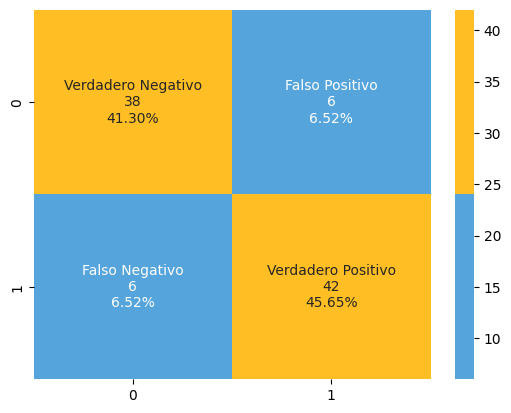

In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

colores = ['#55A4DB','#FFBF24']
# Matriz de confusión

cm = confusion_matrix(Y_test,log_classifier.predict(X_test_enc))
nombres = ['Verdadero Negativo','Falso Positivo','Falso Negativo','Verdadero Positivo']
counts = [value for value in cm.flatten()]
porcentajes = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
etiquetas = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nombres,counts,porcentajes)]
etiquetas = np.asarray(etiquetas).reshape(2,2)
sns.heatmap(cm,annot = etiquetas,cmap = colores,fmt ='')

# Informe con clasificaciones
print(classification_report(Y_test,log_classifier.predict(X_test_enc)))